## Extracting Deep Cognitive Features from Bridge Inspectors Eye Tracking Data

Previous to this study we collected data from five different PhD engineering students on the task of inspecting a bridge in a virtual environment. The students were given 3 minutes to inspect a bridge inside of a Unity platform that we have developed, and take images of any defects, cracks, or areas of concern that they found on the bridge. During their inspection we collected data of their character's movement as well as eye movement. Below you see an example of the type of data that was obtained at one time step:

```xml
<?xml version="1.0" encoding="utf-8"?>
<Data>
  <GazeData>
    <DisplayDimensions Width="1920" Height="1080" />
    <Timestamp>902049965729</Timestamp>
    <GazeOrigin>
      <CombinedGazeRayScreen Origin="(7656.03600000, 927.89240000, -1049.60500000)" Direction="(-0.95211820, -0.28659020, 0.10647600)" Valid="True" />
    </GazeOrigin>
    <pupil average_pupildiameter="4.157799" />
    <IntersectionPoint X="4420.004" Y="-46.16226" Z="-687.7166" />
    <HitObject Name="RW_Bridge_Vologda_II_track_LOD0">
      <ObjectPosition X="0" Y="0" Z="0" />
    </HitObject>
    <PositionOnDisplayArea X="0.5182106" Y="0.5221348" />
  </GazeData>
  <CameraData>
    <Timestamp>902049965729</Timestamp>
    <CameraOrigin X="7656.323" Y="927.9785" Z="-1049.637" />
    <CameraDirection X="-0.9624248" Y="-0.2623872" Z="0.06994079" />
  </CameraData>
<Data>
```

One can see information such as the time of the data point, the location and viewing direction of the inspector at this time as well as the location where their eye were looking. This data was collected at a rate of 60 fps, therefore for 3 minutes of data we have 5400 data points.

### Goal

Our goal in this experiment is to determine whether we can use machine learning to make insights into the cognitive behavior of the inspectors based on this eye tracking data. For example, a successful insight would be if we can correctly identify whether a person is planning, searching, or deciding at every point in their search. For example, when the person is first planning where on the bridge to look, then the person might be actively looking, once the person finds something interesting such as a crack they will be deciding whether this is something they should take a picture of or not.

In addition to these fine-scaled, granular behavioral patterns, we would also like to see if machine learning methods can identify more "big picture" patterns, such as classifying search styles based on a larger set of data.

We believe that the insights gathered from these methods can be used as tools to make concrete data-driven decisions for designing training procedures for new inspectors, or comparing the efficiency of different inspection patterns.

### Methodology

In order to extract deep features from our data we propose two methods. 

The first method consists of using dimensionality reduction and clustering techniques such as PCA, t-SNE, and k-means on manually extracted feature vectors, such as velocity, acceleration, rate of fixations to saccades, etc. Then investigating these reduced dimensionality arrays to determine which combination of features creates the most meaningful feature space.

The second method involves using similar dimensionality reduction techniques on feature vectors extracted from unsupervised feature extraction techniques such as Deep Autoencoders, Variational Autoencoders, LSTM Autoencoders, etc.

We will then visualize the two methods and extract clusters of points, then we will interpret the clusters to find whether they correspond to certain parts of the inspection process or different search patterns. We can apply both of these methods on a global as well as local level to get different types of clustering.

For example, if we apply the method "locally" meaning that we divide the dataset into 1 second intervals and perform the clustering on these 1 second intervals then we expect the clusters to represent local/short term cognitive behavior such as whether a person is searching or planning.

On the other hand, if we perform the clustering "globally" meaning that we use the entire data record we expect the clusters to represent more global characteristics about the search, such as search strategy, or who the inspector is.

Something to keep in mind is that we want to anonymize the data records as much as possible to avoid clustering based on trivial factors such as the exact locations that inspectors looked at or other features that wouldn't generalize well and wouldn't truly represent an inspector's cognitive behavior.

### Table of Contents (TO-DO)


<ul>
    <li>Loading Data</li>
    <li>Local clustering</li>
        <ul>
            <li>Breaking up the data</li>
            <li>Method 1
                <ul>
                    <li>Extracting manual features</li>
                    <li>Trying different clustering techniques</li>
                    <li>Visualizing clusters</li>
                </ul>
            </li>
            <li>Method 2
                <ul>
                    <li>Training Deep AE, VAE, and LSTM AE</li>
                    <li>Extracting deep features</li>
                    <li>Clustering / dimensionality reduction of deep features</li>
                    <li>Visualizing clusters</li>
                </ul>
            </li>
            <li>Testing generality of clusters</li>
            <li>Findings and conclusions</li>
        </ul>
    <li>Global clustering
        <ul>
            <li>Extracting manual global features</li>
            <li>Extracting deep features (Training extractor model)</li>
            <li>Clustering techniques</li>
            <li>Visualizing clusters</li>
            <li>Testing generality of clusters</li>
            <li>Findings and conclusions</li>
        </ul>
    </li>
</ul>

## Loading Data <a name="loading-data"></a>

In this section we will load the data from the different users' xml files.

The data is located in the test_1 folder. The files are divided into two data records for each user, the first data record is for the task of bridge inspection (with suffix "_truss.xml"). The second data record is for the task of looking for a certain object inside a warehouse (with suffix "_warehouse.xml"). We will use the second data record for testing the generality of our clusters, but not for generating the classifiers themselves.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # Use notebook version for better display
import importlib
import data_loader
importlib.reload(data_loader)
import gc
import pickle

In [2]:
# Set plot style
sns.set_theme(style="whitegrid", palette="muted", color_codes=True)

# Specify the folder containing the XML data
DATA_FOLDER = "test_1" # Make sure this folder exists relative to the notebook
# Load the data
truss_data, warehouse_data = data_loader.load_all_data(DATA_FOLDER)

# Display some basic info about the loaded data
if truss_data:
    # Example: Display head of the first truss dataset
    first_key = list(truss_data.keys())[0]
    print(f"\nHead of data for '{first_key}':")
    first_key_df = data_loader.data_dict_to_df(truss_data[first_key])
    display(first_key_df.head())
    print(f"\nInfo for '{first_key}':")
    first_key_df.info()

print("\nTruss Data Keys:", list(truss_data.keys()))
print("\nWarehouse Data Keys:", list(warehouse_data.keys()))

Found 8 XML files in test_1


Loading XML files:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded Ishfaq_truss.xml (17 rows) as key 'Ishfaq_truss'
Loaded Ishfaq_warehouse.xml (17 rows) as key 'Ishfaq_warehouse'
Loaded Mohamad_truss.xml (17 rows) as key 'Mohamad_truss'
Loaded Mohamad_warehouse.xml (17 rows) as key 'Mohamad_warehouse'
Loaded Runze_truss.xml (17 rows) as key 'Runze_truss'
Loaded Runze_warehouse.xml (17 rows) as key 'Runze_warehouse'
Loaded Yuxiang_truss.xml (17 rows) as key 'Yuxiang_truss'
Loaded Yuxiang_warehouse.xml (17 rows) as key 'Yuxiang_warehouse'

Loaded 4 truss datasets.
Loaded 4 warehouse datasets.

Head of data for 'Ishfaq_truss':


,Time_sec,X_2d_X,X_2d_Y,PupilDiameter,GazeOrigin_X,GazeOrigin_Y,GazeOrigin_Z,GazeDirection_X,GazeDirection_Y,GazeDirection_Z,CameraDirection_X,CameraDirection_Y,CameraDirection_Z,CameraOrigin_X,CameraOrigin_Y,CameraOrigin_Z
0,0.000000,0.518211,0.522135,4.157799,7656.036,927.8924,-1049.605,-0.952118,-0.286590,0.106476,-0.962425,-0.262387,0.069941,7656.323,927.9785,-1049.637
1,0.017018,0.515912,0.527296,4.175835,7656.037,927.8907,-1049.606,-0.950918,-0.292255,0.101698,-0.962425,-0.262387,0.069941,7656.323,927.9785,-1049.637
2,0.033244,0.491616,0.474780,4.185173,7656.031,927.9082,-1049.621,-0.970788,-0.233966,0.053210,-0.962425,-0.262387,0.069941,7656.323,927.9785,-1049.637
3,0.049965,0.488096,0.398515,4.163857,7656.024,927.9337,-1049.622,-0.987827,-0.148152,0.047419,-0.962425,-0.262387,0.069941,7656.323,927.9785,-1049.637
4,0.066835,0.499238,0.321722,4.161942,7656.018,927.9594,-1049.615,-0.995547,-0.062378,0.070678,-0.962425,-0.262387,0.069941,7656.323,927.9785,-1049.637



Info for 'Ishfaq_truss':
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11524 entries, 0 to 11523
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time_sec           11524 non-null  float64
 1   X_2d_X             11029 non-null  float64
 2   X_2d_Y             11029 non-null  float64
 3   PupilDiameter      11029 non-null  float64
 4   GazeOrigin_X       11524 non-null  float64
 5   GazeOrigin_Y       11524 non-null  float64
 6   GazeOrigin_Z       11524 non-null  float64
 7   GazeDirection_X    11524 non-null  float64
 8   GazeDirection_Y    11524 non-null  float64
 9   GazeDirection_Z    11524 non-null  float64
 10  CameraDirection_X  11524 non-null  float64
 11  CameraDirection_Y  11524 non-null  float64
 12  CameraDirection_Z  11524 non-null  float64
 13  CameraOrigin_X     11524 non-null  float64
 14  CameraOrigin_Y     11524 non-null  float64
 15  CameraOrigin_Z     11524 non-null  float64
d

## Local Clustering
### Breaking up the data <a name="break-up-data"></a>

For performing local clustering we would like to gather features that represent cognitive behavior at one instance in time. For example, is the person planning right now or are they actively searching? To achieve this we propose to first break up our data records into small instances of time (such as 1s) and then perform the clustering and subsequent analysis on these short time records.

Equally as important, we must anonymize these short time records in order to avoid clustering based on trivial facts. For example, if not anonymized, the clustering analysis could yield clusters that simply divide the data based on location (Such as looking at the top of the deck vs the bottom) but these clusters do not provide any insight into the person's cognitive behavior.

In [3]:
# Define constants
WINDOW_SECONDS = 0.5 # Duration of each local window
SAMPLING_RATE = 60 # Hz (data points per second)
WINDOW_POINTS = int(WINDOW_SECONDS * SAMPLING_RATE)
WINDOW_OVERLAP = 0.8 # Percentage of overlap

print(f"Window size: {WINDOW_SECONDS} seconds ({WINDOW_POINTS} data points)")

USE_SAVED = True  # Set to True to skip processing
SAVE_TO_FILE = "windows_anonymized.pkl"

if USE_SAVED:
    print("Loading saved anonymized windows...")
    with open(SAVE_TO_FILE, "rb") as f:
        all_windows_anonymized = pickle.load(f)
else:
    # Debug mode: reduce load while testing
    all_windows_anonymized = {}
    TEST_KEYS = list(truss_data.keys())[:2]  # Just 2 first for now
    for key in tqdm(TEST_KEYS, desc="Creating & Anonymizing Windows"):
        df = data_loader.data_dict_to_df(truss_data[key])
        windows_raw = data_loader.create_windows(df, WINDOW_POINTS, WINDOW_OVERLAP)
        anonymized_windows = [data_loader.anonymize_window(w) for w in windows_raw]
        all_windows_anonymized[key] = anonymized_windows
        print(f"Processed '{key}': Created {len(windows_raw)} raw windows -> {len(anonymized_windows)} anonymized windows.")
        # Free memory
        del df, windows_raw, anonymized_windows
        gc.collect()
    
    '''# Process all truss data
    all_windows_anonymized = {}
    for key, data in tqdm(truss_data.items(), desc="Creating & Anonymizing Windows"):
        df = data_loader.data_dict_to_df(data)
        windows_raw = data_loader.create_windows(df, WINDOW_POINTS, WINDOW_OVERLAP)
        anonymized_windows = [data_loader.anonymize_window(w) for w in windows_raw]
        all_windows_anonymized[key] = anonymized_windows
        print(f"Processed '{key}': Created {len(windows_raw)} raw windows -> {len(anonymized_windows)} anonymized windows.")'''

        
    with open(SAVE_TO_FILE, "wb") as f:
        pickle.dump(all_windows_anonymized, f)
        print(f"\nSaved anonymized windows to '{SAVE_TO_FILE}'")

# Display and Debug First Anonymized Window
if all_windows_anonymized:
    first_key = list(all_windows_anonymized.keys())[0]
    if all_windows_anonymized[first_key]:
        # Inspect structure and details of anonymized window
        first_window_df = all_windows_anonymized[first_key][0]
        print(f"\nInfo for anonymized window of '{first_key}':")
        first_window_df.info()
    else:
        print(f"No windows created for '{first_key}'.")
    del first_key
    gc.collect()

# Optional Debug: Check windowing step size and start times
first_key = list(all_windows_anonymized.keys())[0]
raw_df = data_loader.data_dict_to_df(truss_data[first_key])
windows_raw = data_loader.create_windows(raw_df, WINDOW_POINTS, WINDOW_OVERLAP)

print("\nChecking start times of the first 5 windows:")
for i, w in enumerate(windows_raw[:5]):
    start_time = w['Time_sec'].iloc[0]
    end_time = w['Time_sec'].iloc[-1]
    print(f"Window {i}: Start = {start_time:.3f}, End = {end_time:.3f}, Rows = {len(w)}")

step_size = int(WINDOW_POINTS * (1 - WINDOW_OVERLAP))
print(f"\nStep size between windows: {step_size} samples")
del windows_raw, first_window_df
gc.collect()

Window size: 0.5 seconds (30 data points)
Loading saved anonymized windows...

Info for anonymized window of 'Ishfaq_truss':
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time_sec           30 non-null     float64
 1   X_2d_X             20 non-null     float64
 2   X_2d_Y             20 non-null     float64
 3   PupilDiameter      20 non-null     float64
 4   GazeOrigin_X       30 non-null     float64
 5   GazeOrigin_Y       30 non-null     float64
 6   GazeOrigin_Z       30 non-null     float64
 7   GazeDirection_X    30 non-null     float64
 8   GazeDirection_Y    30 non-null     float64
 9   GazeDirection_Z    30 non-null     float64
 10  CameraDirection_X  30 non-null     float64
 11  CameraDirection_Y  30 non-null     float64
 12  CameraDirection_Z  30 non-null     float64
 13  CameraOrigin_X     30 non-null     float64
 14 

0

### Method 1
### Extracting manual features <a name="manual-feature-extraction"></a>

After anonymizing the data records we will do some manual feature engineering on our data in order to provide more meaningful features for our clustering algorithms. Based on previous literature we have decided to include the following features:

1. Eye metrics
   - Average pupil diameter (mm)
   - Average eye movement velocity (deg/s)
   - Average eye movement acceleration (deg/s/s)
   - Ratio of fixation/saccade (s)
   - Number of fixations
   - Average fixation duration (s)
   - Spatial variance of fixations (deg)
   - Mean saccade velocity (deg/s)
   - Mean saccade amplitude (deg)
1. Movement patterns (within 1s window)
   - Average movement velocity (m/s)
   - Average turning velocity (deg/s)
   - Total action, including translation and rotation

These features are selected to capture cognitive behavior patterns
while being meaningful within a 1-second analysis window

In [4]:
import manual_features

# Calculate features for all anonymized windows

all_manual_features = []
window_indices = [] # Keep track of which user/window each feature row corresponds to


for key, anonymized_windows in tqdm(all_windows_anonymized.items(), desc="Calculating Manual Features"):
    for i, window_df in enumerate(anonymized_windows):
        features = manual_features.calculate_manual_features_for_window(window_df)
        all_manual_features.append(features)
        window_indices.append({'user_task': key, 'window_index': i})

# Create DataFrames
manual_features_df = pd.DataFrame(all_manual_features)
window_indices_df = pd.DataFrame(window_indices)

# Combine indices with features
manual_features_df = pd.concat([window_indices_df, manual_features_df], axis=1)

print("\nManual Features DataFrame:")
display(manual_features_df.head())
print("\nInfo:")
manual_features_df.info()
print("\nDescription:")
display(manual_features_df.describe())

Calculating Manual Features:   0%|          | 0/2 [00:00<?, ?it/s]


Manual Features DataFrame:


,user_task,window_index,gaze_area_covered,gaze_spatial_density,n_fixations,avg_fixation_duration,fixation_spatial_variance,fix_sacc_ratio,mean_saccade_velocity,mean_saccade_amplitude,avg_pupil_diameter,avg_eye_velocity_degps,avg_eye_accel_degps2,avg_movement_velocity_mps,avg_turning_velocity_degps,total_action
0,Ishfaq_truss,0,7.104569e+06,4.222635e-06,27,0.450000,6.862591e+06,0.900000,40.527702,0.675462,4.175798,4.739348,-0.965158,0.0,0.0,0.0
1,Ishfaq_truss,1,7.104569e+06,4.222635e-06,27,0.450000,7.709826e+06,0.900000,40.527702,0.675462,4.177787,4.164480,-1.980292,0.0,0.0,0.0
2,Ishfaq_truss,2,7.104533e+06,4.222656e-06,27,0.450000,6.438982e+06,0.900000,40.527702,0.675462,4.181248,4.050641,-1.087406,0.0,0.0,0.0
3,Ishfaq_truss,3,7.104516e+06,4.222666e-06,27,0.450000,3.050057e+06,0.900000,40.527702,0.675462,4.183923,3.996809,-3.704074,0.0,0.0,0.0
4,Ishfaq_truss,4,0.000000e+00,3.000000e+06,29,0.483333,0.000000e+00,0.966667,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4535 entries, 0 to 4534
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_task                   4535 non-null   object 
 1   window_index                4535 non-null   int64  
 2   gaze_area_covered           4535 non-null   float64
 3   gaze_spatial_density        4535 non-null   float64
 4   n_fixations                 4535 non-null   int64  
 5   avg_fixation_duration       4535 non-null   float64
 6   fixation_spatial_variance   4535 non-null   float64
 7   fix_sacc_ratio              4535 non-null   float64
 8   mean_saccade_velocity       1245 non-null   float64
 9   mean_saccade_amplitude      1245 non-null   float64
 10  avg_pupil_diameter          4503 non-null   float64
 11  avg_eye_velocity_degps      4535 non-null   float64
 12  avg_eye_accel_degps2        4535 non-null   float64
 13  avg_movement_velocity_mps 

,window_index,gaze_area_covered,gaze_spatial_density,n_fixations,avg_fixation_duration,fixation_spatial_variance,fix_sacc_ratio,mean_saccade_velocity,mean_saccade_amplitude,avg_pupil_diameter,avg_eye_velocity_degps,avg_eye_accel_degps2,avg_movement_velocity_mps,avg_turning_velocity_degps,total_action
count,4535.000000,4.535000e+03,4.535000e+03,4535.000000,4535.000000,4.535000e+03,4535.000000,1245.000000,1245.000000,4503.000000,4535.000000,4535.000000,4535.000000,4535.000000,4535.000000
mean,1133.468798,2.566019e+05,4.167378e+04,27.274972,0.454583,2.326857e+04,0.909166,57.612572,0.960210,4.189170,4.361515,0.173190,282.604084,3.671020,8301.978028
std,655.021850,6.796811e+05,2.747444e+05,3.998679,0.066645,2.807732e+05,0.133289,8.662622,0.144377,0.344416,8.119144,40.134277,348.367971,2.808049,10103.495586
min,0.000000,0.000000e+00,4.222635e-06,9.000000,0.150000,0.000000e+00,0.300000,20.257754,0.337629,3.327717,0.000000,-128.571429,0.000000,0.000000,0.000000
25%,566.500000,1.835535e-01,6.803258e-04,28.000000,0.466667,2.246043e-03,0.933333,60.000000,1.000000,3.909923,0.615352,-0.767294,0.012670,0.000000,162.489686
50%,1133.000000,7.670959e+00,3.910849e+00,29.000000,0.483333,9.648674e+01,0.966667,60.000000,1.000000,4.242331,1.027271,0.000000,102.174993,4.389305,3100.710555
75%,1700.000000,4.409652e+04,1.634311e+02,29.000000,0.483333,2.514931e+03,0.966667,60.000000,1.000000,4.482435,3.172402,0.797543,517.721102,5.814119,15126.228519
max,2298.000000,7.104569e+06,3.000000e+06,29.000000,0.483333,7.709826e+06,0.966667,60.000000,1.000000,5.309740,41.659663,128.571429,1352.198865,16.912321,39379.677384


### Trying different clustering techniques <a name="clustering1"></a>

In this section we will apply clustering techniques to the manual features created above. We will apply the following techniques and explore the clusters created.

1. PCA
2. T-SNE
3. K-means
4. Hierarchical clustering

Using features for clustering: ['gaze_area_covered', 'gaze_spatial_density', 'n_fixations', 'avg_fixation_duration', 'fixation_spatial_variance', 'fix_sacc_ratio', 'mean_saccade_velocity', 'mean_saccade_amplitude', 'avg_pupil_diameter', 'avg_eye_velocity_degps', 'avg_eye_accel_degps2', 'avg_movement_velocity_mps', 'avg_turning_velocity_degps', 'total_action']
Scaled features shape: (4535, 14)

--- Performing PCA ---
Explained variance ratio (first 2 components): [0.40318325 0.14359428]
Total explained variance: 0.5468


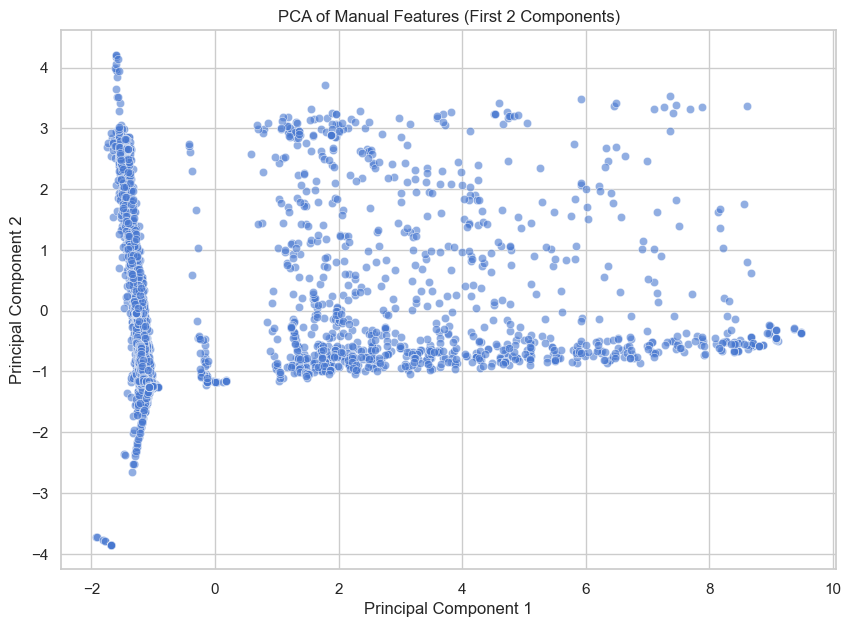


--- Performing T-SNE ---
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4535 samples in 0.011s...
[t-SNE] Computed neighbors for 4535 samples in 0.385s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4535
[t-SNE] Computed conditional probabilities for sample 2000 / 4535
[t-SNE] Computed conditional probabilities for sample 3000 / 4535
[t-SNE] Computed conditional probabilities for sample 4000 / 4535
[t-SNE] Computed conditional probabilities for sample 4535 / 4535
[t-SNE] Mean sigma: 0.188574
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.215187
[t-SNE] KL divergence after 300 iterations: 1.736527


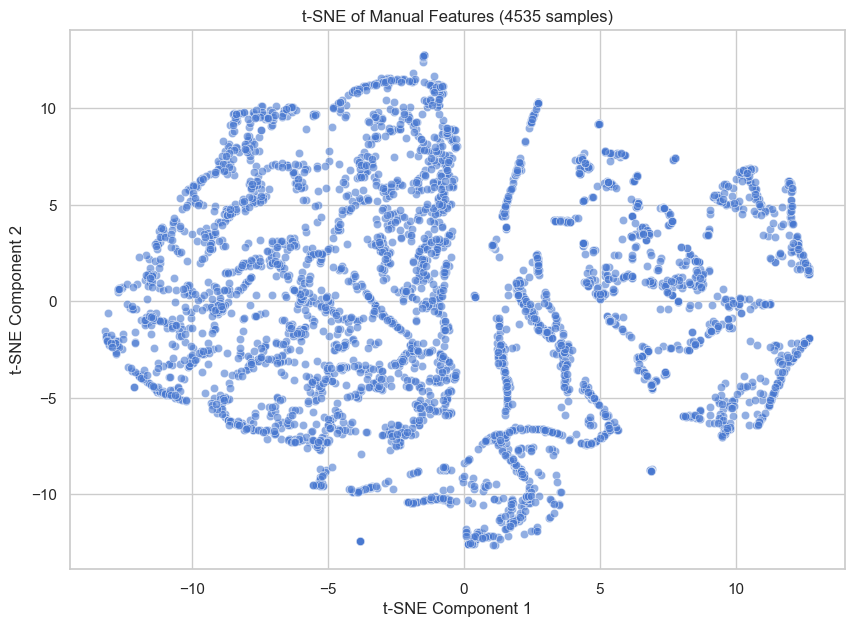


--- Performing K-Means Clustering ---


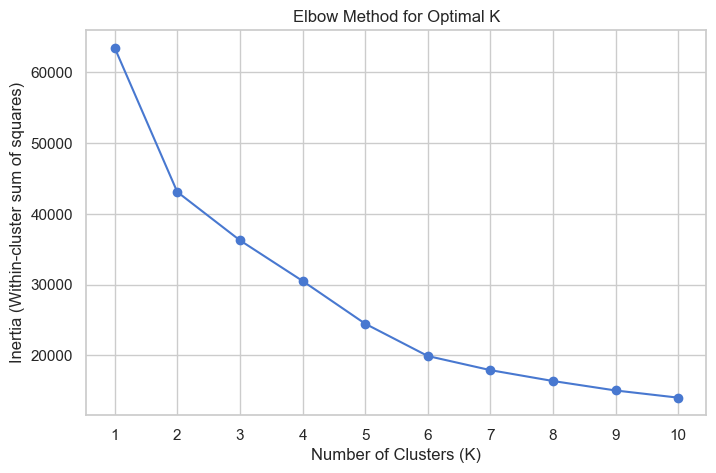

Selected K = 4


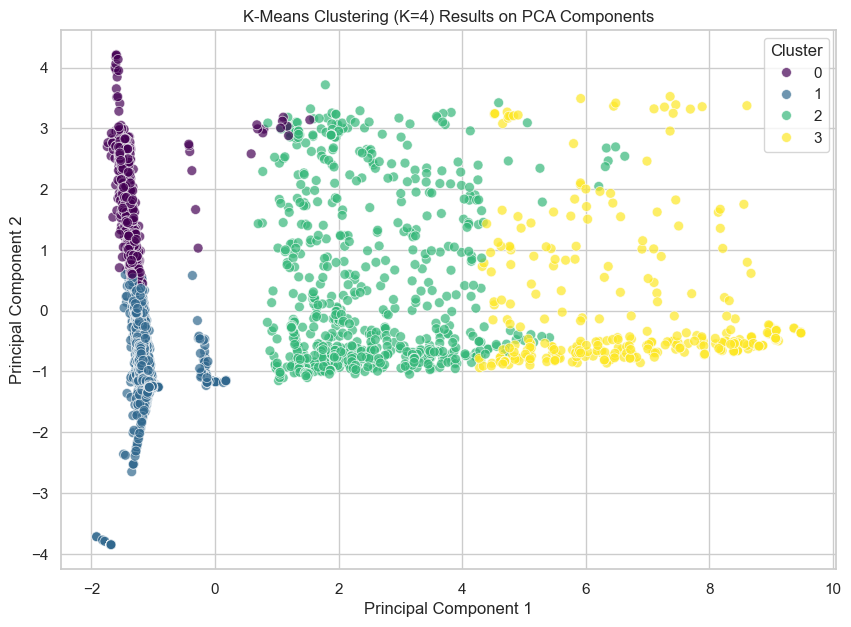


--- Performing Hierarchical Clustering ---


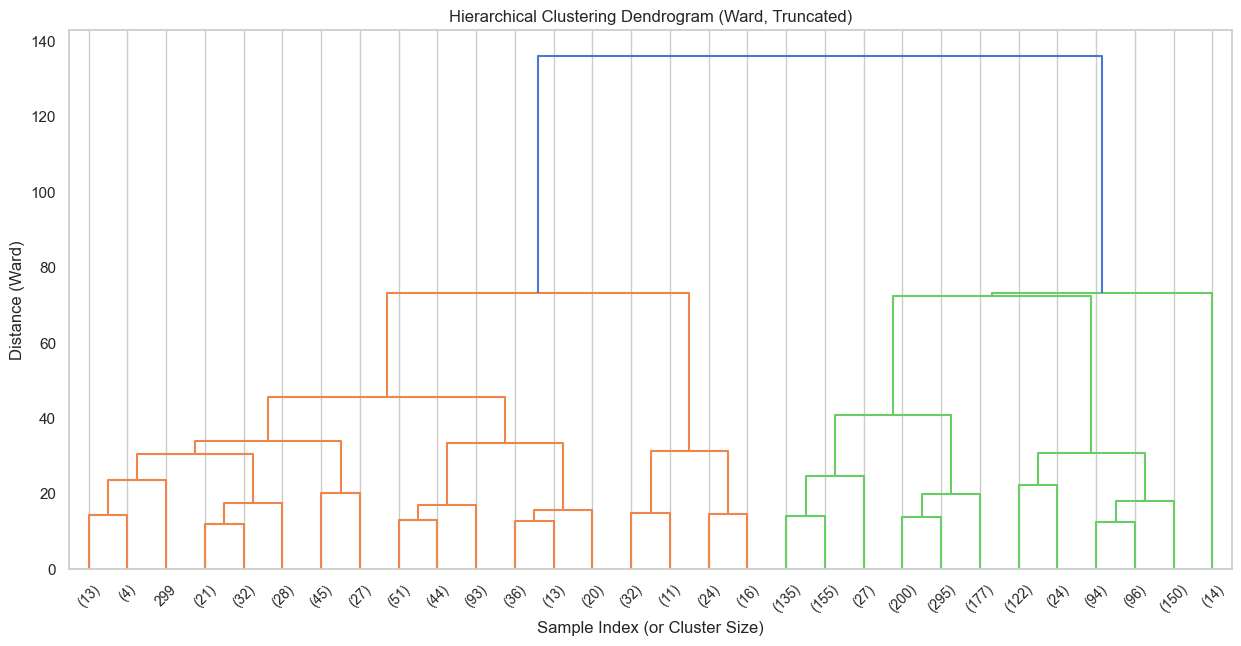

Selected number of hierarchical clusters = 4


C:\Users\xavie\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


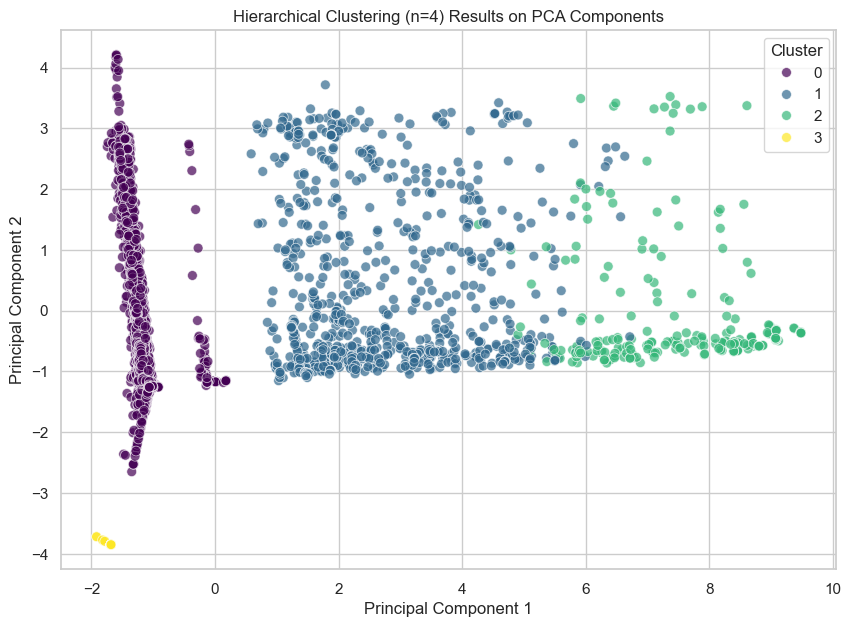

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# --- Data Preparation ---
# Select only the numeric feature columns for clustering
feature_columns = manual_features_df.select_dtypes(include=np.number).columns
# Drop columns that might be constant or have zero variance if they exist
# Also drop index/identifier columns if they were included by mistake
feature_columns = feature_columns.drop(['window_index'], errors='ignore')

print(f"Using features for clustering: {feature_columns.tolist()}")

# Handle potential NaN/Inf values if not already done during feature extraction
features_for_clustering = manual_features_df[feature_columns].fillna(0).replace([np.inf, -np.inf], 0)

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

print(f"Scaled features shape: {scaled_features.shape}")

# --- 1. PCA (Dimensionality Reduction & Visualization) ---
print("\n--- Performing PCA ---")
pca = PCA(n_components=2) # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(scaled_features)
print(f"Explained variance ratio (first 2 components): {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], alpha=0.6)
plt.title('PCA of Manual Features (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# --- 2. T-SNE (Dimensionality Reduction & Visualization) ---
print("\n--- Performing T-SNE ---")
# Note: T-SNE can be computationally expensive on large datasets.
# Consider using a subset or PCA first if it's too slow.
n_samples_tsne = min(5000, scaled_features.shape[0]) # Limit samples for performance
indices = np.random.choice(scaled_features.shape[0], n_samples_tsne, replace=False)
scaled_features_subset = scaled_features[indices, :]
# pca_result_subset = pca_result[indices, :] # Can apply t-SNE on PCA results too

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42, verbose=1)
tsne_result = tsne.fit_transform(scaled_features_subset) # Use subset for T-SNE

plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], alpha=0.6)
plt.title(f't-SNE of Manual Features ({n_samples_tsne} samples)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()


# --- 3. K-Means Clustering ---
print("\n--- Performing K-Means Clustering ---")
# Determine optimal K using the Elbow method
inertia = []
k_range = range(1, 11) # Check K from 1 to 10
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10) # Suppress warning
    kmeans_test.fit(scaled_features)
    inertia.append(kmeans_test.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Choose K based on the elbow plot (e.g., K=4)
optimal_k = 4 # Adjust based on the plot
print(f"Selected K = {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the original features DataFrame (optional)
manual_features_df['kmeans_cluster'] = kmeans_labels

# Visualize K-Means clusters using PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=kmeans_labels, palette='viridis', alpha=0.7, s=50)
plt.title(f'K-Means Clustering (K={optimal_k}) Results on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# --- 4. Hierarchical Clustering ---
print("\n--- Performing Hierarchical Clustering ---")
# Generate the linkage matrix using Ward's method (minimizes variance within clusters)
# Use a subset if the dataset is very large, as linkage calculation can be heavy
n_samples_hc = min(2000, scaled_features.shape[0])
indices_hc = np.random.choice(scaled_features.shape[0], n_samples_hc, replace=False)
scaled_features_subset_hc = scaled_features[indices_hc, :]

linked = linkage(scaled_features_subset_hc, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linked,
           orientation='top',
           # labels=manual_features_df.index[indices_hc].tolist(), # Optional: add labels if meaningful/small subset
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='lastp', # Show only the last p merged clusters
           p=30) # Adjust 'p' to control dendrogram complexity
plt.title('Hierarchical Clustering Dendrogram (Ward, Truncated)')
plt.xlabel('Sample Index (or Cluster Size)')
plt.ylabel('Distance (Ward)') 
plt.grid(axis='y')
plt.show()

# Choose the number of clusters based on the dendrogram (e.g., by cutting at a certain height)
num_hierarchical_clusters = 4 # Adjust based on dendrogram inspection
print(f"Selected number of hierarchical clusters = {num_hierarchical_clusters}")

# Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=num_hierarchical_clusters, affinity='euclidean', linkage='ward')
hierarchical_labels = agg_cluster.fit_predict(scaled_features) # Fit on all data

# Add cluster labels to the original features DataFrame (optional)
manual_features_df['hierarchical_cluster'] = hierarchical_labels

# Visualize Hierarchical clusters using PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=hierarchical_labels, palette='viridis', alpha=0.7, s=50)
plt.title(f'Hierarchical Clustering (n={num_hierarchical_clusters}) Results on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### visualizing clusters <a name="visualize-clusters1"></a>

We will visualize the different clusters created from the algorithms and evaluate whether these clusters correspond to specific cognitive patterns, or any other patterns observed between the different clusters.

## Method 2

### Deep feature extraction and Clustering <a name="deep-feature-extraction"></a>

In this section we will use unsupervised deep learning approaches like Autoencoders, Variational Autoencoders (VAE), and LSTM Autoencoders to extract latent features from the raw data or the manually selected features.

### Exploring deep feature clusters

We will again use algorithms such as PCA, t-SNE, k-means and hierarchical clustering to cluster the deep features and visualize the latent space. As done before we will evaluate whether these clusters correspond to specific patterns in the inspections.

## Testing generality of clusters

To test the generality of these cluster we will load the warehouse data. For this dataset the user was asked to find a specific graffiti inside a warehouse full of graffiti. Although the task is very different in nature, the cognitive patterns should be similar, for example the clusters should be capable of identifying when the person is looking at a graffiti and deciding if it is the correct one or not. On the other hand, we might find that the clusters generated don't generalize well to this problem.